# Metodi iterativi

- Volpato Mattia 866316
- Andreotti Stefano 851596

## Importazione librerie

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

from matspy import spy

import time

## Definizione di constanti

In [2]:
SPA_1_PATH = './matrici/spa1.mtx'
SPA_2_PATH = './matrici/spa2.mtx'
VEM_1_PATH = './matrici/vem1.mtx'
VEM_2_PATH = './matrici/vem2.mtx'

DEFAULT_FIGSIZE = 5

DEFAULT_DPI = 300

## Caricamento matrici

### SPA

Matrici sparse

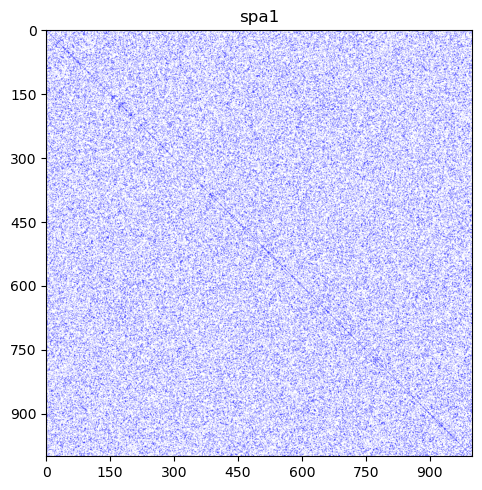

Non-zero entries: 182264, 18.23%


In [3]:
spa1 = sp.io.mmread(SPA_1_PATH).tocsr()
spy(spa1, title='spa1', figsize=DEFAULT_FIGSIZE, dpi=DEFAULT_DPI)
print(f"Non-zero entries: {spa1.count_nonzero()}, {spa1.count_nonzero() / (spa1.shape[0] * spa1.shape[1]) * 100:.2f}%")

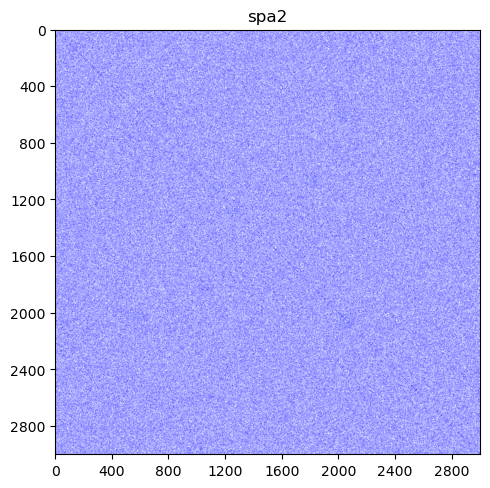

Non-zero entries: 1631738, 18.13 %


In [4]:
spa2 = sp.io.mmread(SPA_2_PATH).tocsr()
spy(spa2, title='spa2', figsize=DEFAULT_FIGSIZE, dpi=DEFAULT_DPI)
print(f"Non-zero entries: {spa2.count_nonzero()}, {spa2.count_nonzero() / (spa2.shape[0] * spa2.shape[1]) * 100:.2f} %")

### VEM

Matrici a bande

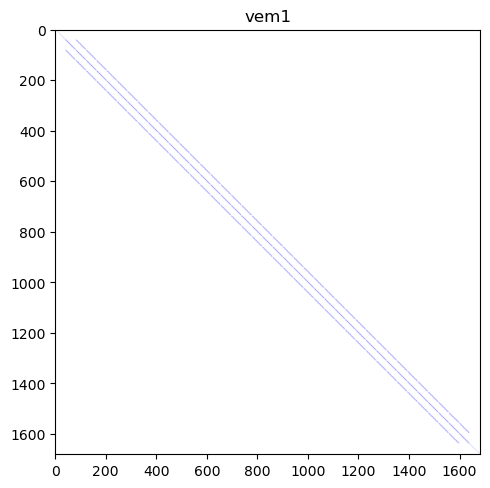

Non-zero entries: 13385, 0.47 %


In [5]:
vem1 = sp.io.mmread(VEM_1_PATH).tocsr()
spy(vem1, title='vem1', figsize=DEFAULT_FIGSIZE, dpi=DEFAULT_DPI)
print(f"Non-zero entries: {vem1.count_nonzero()}, {vem1.count_nonzero() / (vem1.shape[0] * vem1.shape[1]) * 100:.2f} %")

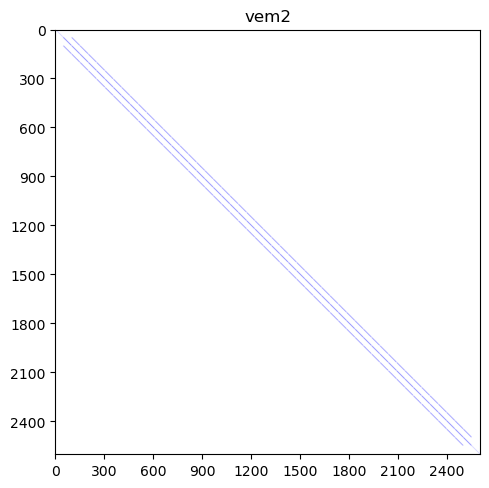

Non-zero entries: 21225, 0.31 %


In [6]:
vem2 = sp.io.mmread(VEM_2_PATH).tocsr()
spy(vem2, title='vem2', figsize=DEFAULT_FIGSIZE, dpi=DEFAULT_DPI)
print(f"Non-zero entries: {vem2.count_nonzero()}, {vem2.count_nonzero() / (vem2.shape[0] * vem2.shape[1]) * 100:.2f} %")

## Creazione del termine noto *b* e della soluzione iniziale $x_0$

In [7]:
def create_b(A:sp.sparse.csr_matrix, x:np.ndarray=None) -> np.ndarray:
    if x is None:
        x = np.ones(A.shape[1], dtype=np.float64)
        
    return A.dot(x)

In [8]:
def initialize_x_0(N:int, mode:str='zeros', L:float=-1, U:float=1) -> np.ndarray:
    if mode == 'random':
        return np.random.uniform(L, U, N)

    return np.zeros(N, dtype=np.float64)

In [9]:
MODE = 'zeros'

### SPA1

In [10]:
b_spa1 = create_b(spa1)
x_0_spa1 = initialize_x_0(spa1.shape[0], mode=MODE)

assert len(b_spa1) == spa1.shape[0] == spa1.shape[0] == len(x_0_spa1), "Shapes mismatch"

b_spa1.shape, x_0_spa1.shape

((1000,), (1000,))

### SPA2

In [11]:
b_spa2 = create_b(spa2)
x_0_spa2 = initialize_x_0(spa2.shape[0], mode=MODE)

assert len(b_spa2) == spa2.shape[0] == spa2.shape[0] == len(x_0_spa2), "Shapes mismatch"

b_spa2.shape, x_0_spa2.shape

((3000,), (3000,))

### VEM1

In [12]:
b_vem1 = create_b(vem1)
x_0_vem1 = initialize_x_0(vem1.shape[0], mode=MODE)

assert len(b_vem1) == vem1.shape[0] == vem1.shape[0] == len(x_0_vem1), "Shapes mismatch"

b_vem1.shape, x_0_vem1.shape

((1681,), (1681,))

### VEM2

In [13]:
b_vem2 = create_b(vem2)
x_0_vem2 = initialize_x_0(vem2.shape[0], mode=MODE)

assert len(b_vem2) == vem2.shape[0] == vem2.shape[0] == len(x_0_vem2), "Shapes mismatch"

b_vem2.shape, x_0_vem2.shape

((2601,), (2601,))

## Condizione di terminazione

In [14]:
def check_termination(r:np.array, b:np.ndarray, epsilon:float) -> bool:
    return np.linalg.norm(r) / np.linalg.norm(b) < epsilon

## Funzione metodi iterativi

In [15]:
def solve(check_termination:callable, update_x:callable, 
          A:sp.sparse.csr_matrix, b:np.ndarray, x_0:np.ndarray, 
          max_iter:int, epsilon:float, support:any=None) -> tuple[np.ndarray, int]:
    
    x = x_0.copy()
    k = 0
    r = b - A.dot(x)

    while not check_termination(r, b, epsilon):
        x, r, support = update_x(A, b, x, support)
        k += 1
        
        if k > max_iter:
            break

    return x, k

## Funzione di testing

In [16]:
matrixes = [spa1, spa2, vem1, vem2]
b = [b_spa1, b_spa2, b_vem1, b_vem2]
x_0 = [x_0_spa1, x_0_spa2, x_0_vem1, x_0_vem2]
matrixes_names = ['spa1', 'spa2', 'vem1', 'vem2']

In [17]:
def test(solver:callable, epsilon:float, max_iter:int, n_test:int=1, check_correctness:bool=True, verbose:bool=False):
    matrixes_times = {}

    for i, matrix in enumerate(matrixes):
        if verbose:
            print(f"Testing matrix {matrixes_names[i]} ({i + 1}/{len(matrixes)})")

        matrixes_times[matrixes_names[i]] = {}
        matrix_times = []
        failed, reason = False, None

        for j in range(n_test):
            if verbose:
                print(f"\tTest {j + 1}/{n_test}: ", end="")

            start = time.time()
            solution, iterations = solver(matrix, b[i], x_0[i], epsilon, max_iter)
            end = time.time()

            matrix_times.append(end - start)

            if iterations > max_iter:
                failed = True
                reason = "MAX_ITER_FAIL"
                if verbose:
                    print("Failed for max iterations=", iterations)
                break

            if check_correctness:
                if not np.allclose(matrix.dot(solution), b[i], atol=epsilon + epsilon * 1/2):
                    failed = True
                    reason = "CORRECTNESS_FAIL"
                    if verbose:
                        print("Failed for correctness")
                        print(f"x: {solution}")
                    break
            
            if verbose:
                print(f"Passed with {iterations} iterations in {matrix_times[-1]} s")

        if not failed:
            matrixes_times[matrixes_names[i]]['time'] = np.mean(matrix_times)
            matrixes_times[matrixes_names[i]]['iter'] = iterations
        else:
            matrixes_times[matrixes_names[i]] = reason

    return matrixes_times

## Parametri

In [18]:
MAX_ITER = 20000
EPSILON = 1e-9
N_TEST = 3
CHECK_CORRECTNESS = True
VERBOSE = True

## Metodo di Jacobi

In [19]:
def jacobi_update(A:sp.sparse.csr_matrix, b:np.ndarray, x:np.ndarray, 
                  P_inv:sp.sparse.csr_matrix) -> tuple[np.array, np.array, sp.sparse.csr_matrix]:
    
    r = b - A.dot(x)
    x = x + P_inv.dot(r)

    return x, r, P_inv

In [20]:
jacobi_solver = lambda A, b, x_0, epsilon, max_iter: solve(check_termination, jacobi_update, A, b, x_0, max_iter, epsilon, sp.sparse.diags(1 / A.diagonal(), format='csr'))

In [21]:
solution, iterations = jacobi_solver(matrixes[0], b[0], x_0[0], 10e-6, 20000)
solution

array([1.00000243, 1.0000032 , 1.00000331, 1.0000113 , 1.00000305,
       1.0000013 , 1.00000634, 1.00000407, 1.00000317, 1.00000693,
       1.00000346, 1.00000518, 1.00000413, 1.00000798, 1.00000193,
       1.00000229, 1.00000267, 1.00000859, 1.00000177, 1.00001413,
       1.00000294, 1.0000692 , 1.00001584, 1.00004318, 1.00001046,
       1.00000592, 1.0000036 , 1.0000014 , 1.00003191, 1.00001206,
       1.00000285, 1.00016778, 1.00000214, 1.00000885, 1.00000208,
       1.00000523, 1.00000342, 1.00000207, 1.00000861, 1.00000192,
       1.00000165, 1.0000106 , 1.00001028, 1.0000051 , 1.00001116,
       1.0000091 , 1.00000428, 1.00000644, 1.0000298 , 1.0000016 ,
       1.00000343, 1.00000424, 1.00000147, 1.00000301, 1.00001619,
       1.00000826, 1.00000512, 1.00026554, 1.00000346, 1.00000564,
       1.00000577, 1.00000999, 1.00000121, 1.0000024 , 1.00005664,
       1.000002  , 1.00000462, 1.00000303, 1.00000553, 1.00002558,
       1.00000326, 1.00000804, 1.00000249, 1.00001119, 1.00000

In [22]:
test(jacobi_solver, epsilon=EPSILON, max_iter=MAX_ITER, n_test=N_TEST, check_correctness=CHECK_CORRECTNESS, verbose=VERBOSE)

Testing matrix spa1 (1/4)
	Test 1/3: Passed with 281 iterations in 0.0918428897857666 s
	Test 2/3: Passed with 281 iterations in 0.07966303825378418 s
	Test 3/3: Passed with 281 iterations in 0.07902932167053223 s
Testing matrix spa2 (2/4)
	Test 1/3: Passed with 89 iterations in 0.2399463653564453 s
	Test 2/3: Passed with 89 iterations in 0.2637465000152588 s
	Test 3/3: Passed with 89 iterations in 0.22742295265197754 s
Testing matrix vem1 (3/4)
	Test 1/3: Passed with 4113 iterations in 0.16529393196105957 s
	Test 2/3: Passed with 4113 iterations in 0.16939592361450195 s
	Test 3/3: Passed with 4113 iterations in 0.16296958923339844 s
Testing matrix vem2 (4/4)
	Test 1/3: Passed with 6300 iterations in 0.3209848403930664 s
	Test 2/3: Passed with 6300 iterations in 0.35179615020751953 s
	Test 3/3: Passed with 6300 iterations in 0.34807443618774414 s


{'spa1': {'time': 0.08351174990336101, 'iter': 281},
 'spa2': {'time': 0.24370527267456055, 'iter': 89},
 'vem1': {'time': 0.16588648160298666, 'iter': 4113},
 'vem2': {'time': 0.3402851422627767, 'iter': 6300}}

In [23]:
epsilons = [1e-3, 1e-6, 1e-9, 1e-12]
max_iters = [20000, 20000, 20000, 20000]
n_tests = [3, 3, 3, 3]
check_correctnesses = [False, False, False, False]
verboses = [False, False, False, False]

jacobi_epsilon_df = pd.DataFrame(zip(epsilons, max_iters, n_tests), columns=['epsilon', 'max_iter', 'n_test'])
for name in matrixes_names:
    jacobi_epsilon_df[name + '_time'] = None
    jacobi_epsilon_df[name + '_iter'] = None

for i in range(len(epsilons)):
    result_dict = test(jacobi_solver, epsilon=epsilons[i], max_iter=max_iters[i], n_test=n_tests[i], 
                                      check_correctness=check_correctnesses[i], verbose=verboses[i])

    for j, name in enumerate(result_dict):
        jacobi_epsilon_df.loc[i, name + '_time'] = result_dict[name]['time']
        jacobi_epsilon_df.loc[i, name + '_iter'] = result_dict[name]['iter']

jacobi_epsilon_df

,epsilon,max_iter,n_test,spa1_time,spa1_iter,spa2_time,spa2_iter,vem1_time,vem1_iter,vem2_time,vem2_iter
0,1.000000e-03,20000,3,0.029757,83,0.071968,27,0.025672,756,0.054711,1054
1,1.000000e-06,20000,3,0.062816,182,0.177748,58,0.100314,2434,0.189944,3677
2,1.000000e-09,20000,3,0.080637,281,0.242089,89,0.166903,4113,0.325878,6300
3,1.000000e-12,20000,3,0.107242,381,0.32888,120,0.238195,5791,0.438811,8924


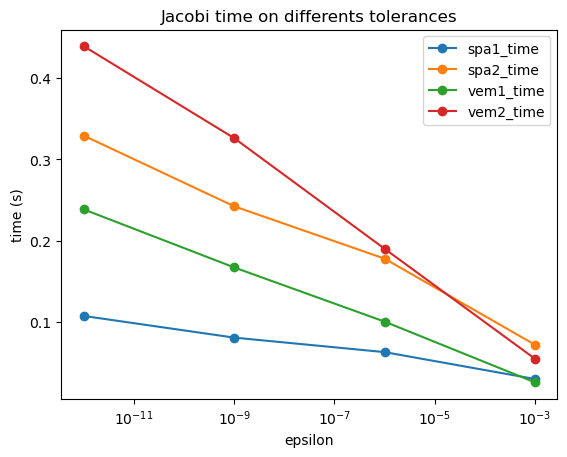

In [24]:
jacobi_epsilon_df[['epsilon', 'spa1_time', 
                    'spa2_time', 'vem1_time', 'vem2_time']].plot(x='epsilon', kind='line', ylabel='time (s)', 
                                                                logx=True, marker='o', 
                                                                title='Jacobi time on differents tolerances')

plt.show()

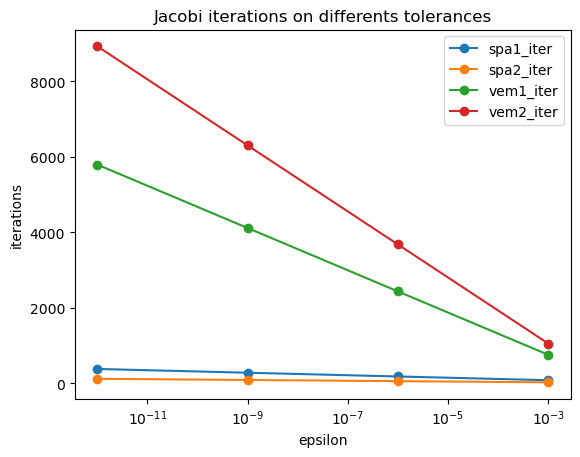

In [25]:
jacobi_epsilon_df[['epsilon', 'spa1_iter', 
                    'spa2_iter', 'vem1_iter', 'vem2_iter']].plot(x='epsilon', kind='line', ylabel='iterations', 
                                                                logx=True, marker='o', 
                                                                title='Jacobi iterations on differents tolerances')
plt.show()

In [33]:
jacobi_sparsity_df = pd.DataFrame([(matrixes_names[i], matrixes[i].shape[0], matrixes[i].count_nonzero(), matrixes[i].count_nonzero() / (matrixes[i].shape[0] * matrixes[i].shape[1])) for i in range(len(matrixes))],
                                    columns=['name', 'N', 'nonzero_entries', 'sparsity_index'])

row = 2
jacobi_sparsity_df['time (s)'] = jacobi_epsilon_df.loc[row, [name + '_time' for name in matrixes_names]].values
jacobi_sparsity_df['iter'] = jacobi_epsilon_df.loc[row, [name + '_iter' for name in matrixes_names]].values

jacobi_sparsity_df            

,name,N,nonzero_entries,sparsity_index,time (s),iter
0,spa1,1000,182264,0.182264,0.080637,281
1,spa2,3000,1631738,0.181304,0.242089,89
2,vem1,1681,13385,0.004737,0.166903,4113
3,vem2,2601,21225,0.003137,0.325878,6300


## Metodo di Gauss-Seidel
    
Risolve un sistema lineare Ax = b usando il metodo di Gauss-Seidel.

Parametri:
    A: matrice dei coefficienti (matrice sparsa).
    b: vettore dei termini noti.
    x0: vettore di partenza (soluzione iniziale).
    tol: tolleranza di convergenza.
    max_iter: numero massimo di iterazioni.

Ritorna:
    x: vettore approssimato della soluzione.


In [27]:
def forward_substitution_naive(L:sp.sparse.csr_matrix, b:np.array) -> np.array:
    n = L.shape[0]
    x = np.zeros(n, dtype=np.float64)

    if not np.all(L.diagonal()):
        raise ValueError("Matrix L has zeros on the diagonal: forward substitution not applicable.")

    x[0] = b[0] / L[0, 0]
    
    for i in range(1, n):
        x[i] = (b[i] - L[i, :i].toarray().flatten().dot(x[:i])) / L[i, i]  

    return x

In [28]:
from scipy.linalg import solve_triangular

forward_substitution_scipy = lambda L, b: solve_triangular(L.toarray(), b, lower=True)

In [29]:
def gauss_seidel_update(A:sp.sparse.csr_matrix, b:np.ndarray, x:np.ndarray,
                        P:sp.sparse.csr_matrix) -> tuple[np.array, np.array, sp.sparse.csr_matrix]:
    
    r = b - A.dot(x)
    y = forward_substitution_scipy(P, r)
    x = x + y

    return x, r, P

In [30]:
gauss_seidel_solver = lambda A, b, x_0, epsilon, max_iter: solve(check_termination, gauss_seidel_update, A, b, x_0, max_iter, epsilon, sp.sparse.tril(A, format='csr'))

In [31]:
solution, iterations = gauss_seidel_solver(matrixes[0], b[0], x_0[0], 10e-6, 20000)
solution

array([0.99999405, 0.99999308, 1.00000168, 0.99995757, 0.99998901,
       1.00000257, 0.9999991 , 1.00000902, 1.00000033, 1.00000068,
       1.00001311, 0.99997809, 0.99999775, 0.9999814 , 1.00000385,
       0.99999963, 1.00001013, 1.0000177 , 1.00000188, 1.00001854,
       1.00000438, 1.00004674, 0.99994704, 0.99961994, 1.00001352,
       0.99999683, 0.99997304, 0.99999896, 1.00006649, 1.00000096,
       1.00001151, 1.00042493, 1.00000494, 0.99996495, 1.00000226,
       1.00000495, 1.00000473, 1.00000189, 0.99996831, 1.00000159,
       1.00000333, 0.9999622 , 0.99991957, 0.99997102, 1.00001563,
       1.00000467, 0.99999154, 1.00001367, 1.00004924, 1.00000118,
       1.0000039 , 0.99999033, 0.9999981 , 0.99998085, 0.99995426,
       0.99992869, 1.00000215, 0.99830112, 0.99999933, 0.99997558,
       0.99999319, 0.99992878, 1.00000152, 1.00000323, 0.99968819,
       1.00000549, 1.00000903, 1.00001246, 0.99999031, 1.00003445,
       1.00000715, 0.99997863, 1.00000364, 0.99991294, 1.00000

In [35]:
test(gauss_seidel_solver, epsilon=EPSILON, max_iter=MAX_ITER, n_test=1, check_correctness=CHECK_CORRECTNESS, verbose=VERBOSE)

Testing matrix spa1 (1/4)
	Test 1/1: Passed with 29 iterations in 0.09733915328979492 s
Testing matrix spa2 (2/4)
	Test 1/1: Passed with 15 iterations in 1.096409559249878 s
Testing matrix vem1 (3/4)
	Test 1/1: Passed with 2059 iterations in 10.727544784545898 s
Testing matrix vem2 (4/4)
	Test 1/1: Passed with 3153 iterations in 84.8868350982666 s


{'spa1': {'time': 0.09733915328979492, 'iter': 29},
 'spa2': {'time': 1.096409559249878, 'iter': 15},
 'vem1': {'time': 10.727544784545898, 'iter': 2059},
 'vem2': {'time': 84.8868350982666, 'iter': 3153}}

In [34]:
epsilons = [1e-3, 1e-6, 1e-9, 1e-12]
max_iters = [20000, 20000, 20000, 20000]
n_tests = [1, 1, 1, 1]
check_correctnesses = [False, False, False, False]
verboses = [False, False, False, False]

gauss_seidel_epsilon_df = pd.DataFrame(zip(epsilons, max_iters, n_tests), columns=['epsilon', 'max_iter', 'n_test'])
for name in matrixes_names:
    gauss_seidel_epsilon_df[name + '_time'] = None
    gauss_seidel_epsilon_df[name + '_iter'] = None

for i in range(len(epsilons)):
    result_dict = test(gauss_seidel_solver, epsilon=epsilons[i], max_iter=max_iters[i], n_test=n_tests[i], 
                                      check_correctness=check_correctnesses[i], verbose=verboses[i])

    for j, name in enumerate(result_dict):
        gauss_seidel_epsilon_df.loc[i, name + '_time'] = result_dict[name]['time']
        gauss_seidel_epsilon_df.loc[i, name + '_iter'] = result_dict[name]['iter']

gauss_seidel_epsilon_df

,epsilon,max_iter,n_test,spa1_time,spa1_iter,spa2_time,spa2_iter,vem1_time,vem1_iter,vem2_time,vem2_iter
0,1.000000e-03,20000,1,0.024136,6,0.332716,5,1.955831,380,15.426307,529
1,1.000000e-06,20000,1,0.045091,18,0.618585,9,7.20227,1219,51.951245,1841
2,1.000000e-09,20000,1,0.070511,29,0.979588,15,9.927018,2059,85.557029,3153
3,1.000000e-12,20000,1,0.097071,40,1.285896,20,14.619475,2898,120.6987,4465


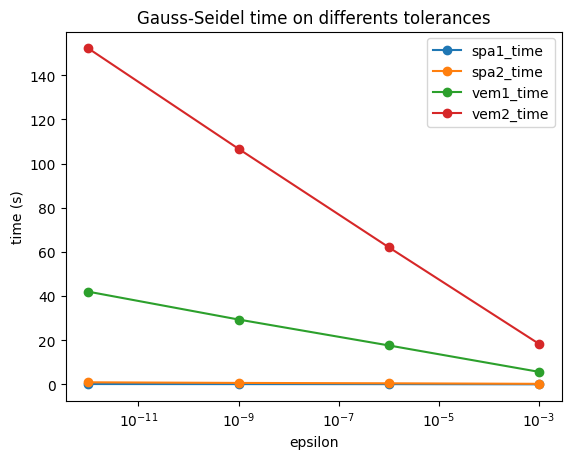

In [34]:
gauss_seidel_epsilon_df[['epsilon', 'spa1_time', 
                    'spa2_time', 'vem1_time', 'vem2_time']].plot(x='epsilon', kind='line', ylabel='time (s)', 
                                                                logx=True, marker='o', 
                                                                title='Gauss-Seidel time on differents tolerances')

plt.show() 

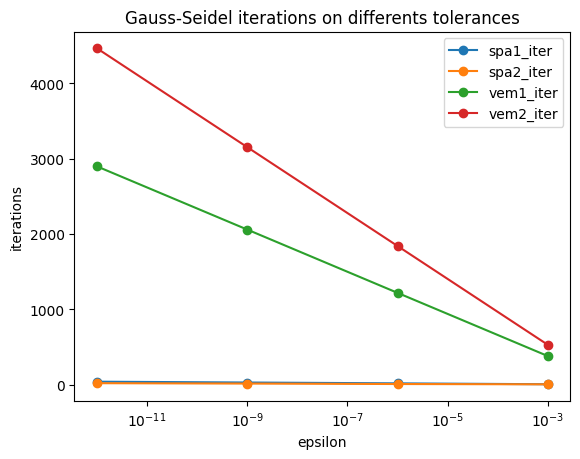

In [35]:
gauss_seidel_epsilon_df[['epsilon', 'spa1_iter', 
                        'spa2_iter', 'vem1_iter', 'vem2_iter']].plot(x='epsilon', kind='line', ylabel='iterations', 
                                                                logx=True, marker='o', 
                                                                title='Gauss-Seidel iterations on differents tolerances')
plt.show()

In [36]:
gauss_seidel_sparsity_df = pd.DataFrame([(matrixes_names[i], matrixes[i].shape[0], matrixes[i].count_nonzero(), matrixes[i].count_nonzero() / (matrixes[i].shape[0] * matrixes[i].shape[1])) for i in range(len(matrixes))],
                                    columns=['name', 'N', 'nonzero_entries', 'sparsity_index'])

row = 2
gauss_seidel_sparsity_df['time (s)'] = gauss_seidel_epsilon_df.loc[row, [name + '_time' for name in matrixes_names]].values
gauss_seidel_sparsity_df['iter'] = gauss_seidel_epsilon_df.loc[row, [name + '_iter' for name in matrixes_names]].values

gauss_seidel_sparsity_df  

,name,N,nonzero_entries,sparsity_index,times,iter
0,spa1,1000,182264,0.182264,0.131654,29
1,spa2,3000,1631738,0.181304,0.667321,15
2,vem1,1681,13385,0.004737,29.387856,2059
3,vem2,2601,21225,0.003137,106.721494,3153


## Metodo di discesa del gradiente
    
Risolve un sistema lineare Ax = b usando il metodo del Gradiente.

Parametri:
    A: matrice dei coefficienti (matrice sparsa).
    b: vettore dei termini noti.
    x0: vettore di partenza (soluzione iniziale).
    alpha: coefficiente di passo.
    tol: tolleranza di convergenza.
    max_iter: numero massimo di iterazioni.

Ritorna:
    x: vettore approssimato della soluzione.

In [37]:
def gradient_update(A:sp.sparse.csr_matrix, b:np.ndarray, x:np.ndarray, _:any) -> tuple[np.array, np.array, any]:
    r = b - A * x
    y = A * r

    a = r @ r           # Dot product
    c = r @ y           # Dot product
    x = x + a / c * r

    return x, r, _

In [38]:
gradient_solver = lambda A, b, x_0, epsilon, max_iter: solve(check_termination, gradient_update, A, b, x_0, max_iter, epsilon)

In [39]:
solution, iterations = gradient_solver(matrixes[0], b[0], x_0[0], 10e-6, 20000)
solution

array([1.00001581, 1.00004899, 1.00002603, 1.00033194, 1.00003932,
       0.99998578, 1.00019514, 1.00002682, 0.99996973, 0.9999784 ,
       0.99993542, 1.00018146, 1.00003779, 1.00015292, 0.99996563,
       1.00001841, 0.99995961, 0.999914  , 0.99997548, 0.99992962,
       1.00003057, 1.00131973, 1.00046461, 1.0016675 , 1.00018602,
       0.9999919 , 1.00010761, 0.99999426, 0.999586  , 1.00045948,
       0.9999504 , 0.99741034, 0.99996795, 1.00029747, 1.00002068,
       0.99993462, 0.99996638, 0.9999798 , 1.00025902, 0.99998543,
       0.99997505, 1.00022044, 1.00035369, 1.00012791, 0.99989292,
       1.00030417, 1.00003312, 0.99989253, 0.9996766 , 1.00000036,
       0.99996539, 1.00004021, 1.00000122, 1.00007681, 1.00014023,
       1.00031965, 1.00000365, 1.00998984, 0.99999304, 1.00019097,
       1.00009293, 1.00031162, 0.99998779, 0.99996998, 1.00130437,
       0.9999974 , 0.99996845, 0.99993749, 1.00003323, 0.99967197,
       0.99997688, 1.00007383, 0.99998402, 1.00037285, 0.99995

In [40]:
test(gradient_solver, epsilon=EPSILON, max_iter=MAX_ITER, n_test=1, check_correctness=CHECK_CORRECTNESS, verbose=VERBOSE)

Testing matrix spa1 (1/4)
	Test 1/1: Passed with 10576 iterations in 5.741968393325806 s
Testing matrix spa2 (2/4)
	Test 1/1: Passed with 6682 iterations in 33.19655799865723 s
Testing matrix vem1 (3/4)
	Test 1/1: Passed with 2697 iterations in 0.16951274871826172 s
Testing matrix vem2 (4/4)
	Test 1/1: Passed with 4131 iterations in 0.3318796157836914 s


{'spa1': {'time': 5.741968393325806, 'iter': 10576},
 'spa2': {'time': 33.19655799865723, 'iter': 6682},
 'vem1': {'time': 0.16951274871826172, 'iter': 2697},
 'vem2': {'time': 0.3318796157836914, 'iter': 4131}}

In [41]:
epsilons = [1e-3, 1e-6, 1e-9, 1e-12]
max_iters = [20000, 20000, 20000, 20000]
n_tests = [1, 1, 1, 1]
check_correctnesses = [False, False, False, False]
verboses = [False, False, False, False]

gradient_epsilon_df = pd.DataFrame(zip(epsilons, max_iters, n_tests), columns=['epsilon', 'max_iter', 'n_test'])
for name in matrixes_names:
    gradient_epsilon_df[name + '_time'] = None
    gradient_epsilon_df[name + '_iter'] = None

for i in range(len(epsilons)):
    result_dict = test(gradient_solver, epsilon=epsilons[i], max_iter=max_iters[i], n_test=n_tests[i], 
                                      check_correctness=check_correctnesses[i], verbose=verboses[i])

    for j, name in enumerate(result_dict):
        gradient_epsilon_df.loc[i, name + '_time'] = result_dict[name]['time']
        gradient_epsilon_df.loc[i, name + '_iter'] = result_dict[name]['iter']

gradient_epsilon_df

,epsilon,max_iter,n_test,spa1_time,spa1_iter,spa2_time,spa2_iter,vem1_time,vem1_iter,vem2_time,vem2_iter
0,1.000000e-03,20000,1,0.033591,44,0.268304,42,0.036706,529,0.064317,745
1,1.000000e-06,20000,1,1.863628,3578,9.634269,1950,0.085592,1613,0.179305,2439
2,1.000000e-09,20000,1,5.132789,10576,33.244131,6682,0.149694,2697,0.283141,4131
3,1.000000e-12,20000,1,8.466916,17608,55.174696,11506,0.200524,3783,0.433676,5825


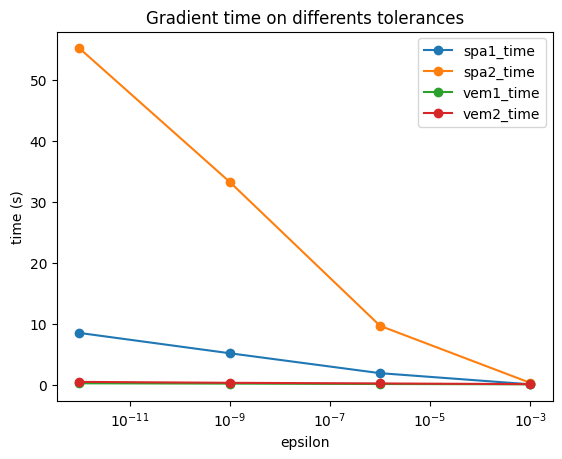

In [42]:
gradient_epsilon_df[['epsilon', 'spa1_time', 
                    'spa2_time', 'vem1_time', 'vem2_time']].plot(x='epsilon', kind='line', ylabel='time (s)', 
                                                                logx=True, marker='o', 
                                                                title='Gradient time on differents tolerances')

plt.show() 

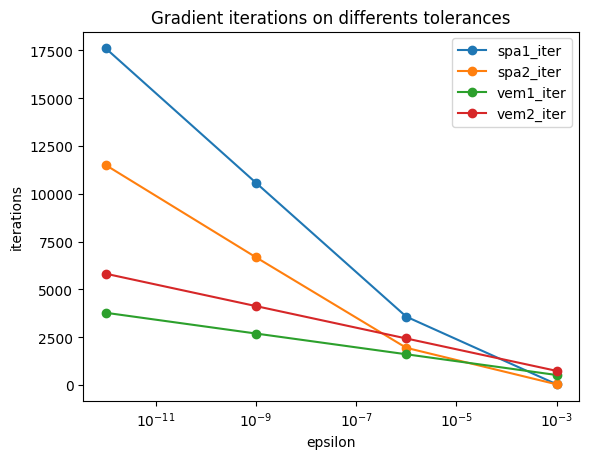

In [43]:
gradient_epsilon_df[['epsilon', 'spa1_iter', 
                        'spa2_iter', 'vem1_iter', 'vem2_iter']].plot(x='epsilon', kind='line', ylabel='iterations', 
                                                                logx=True, marker='o', 
                                                                title='Gradient iterations on differents tolerances')
plt.show()

In [44]:
gradient_sparsity_df = pd.DataFrame([(matrixes_names[i], matrixes[i].shape[0], matrixes[i].count_nonzero(), matrixes[i].count_nonzero() / (matrixes[i].shape[0] * matrixes[i].shape[1])) for i in range(len(matrixes))],
                                    columns=['name', 'N', 'nonzero_entries', 'sparsity_index'])

row = 2
gradient_sparsity_df['time (s)'] = gradient_epsilon_df.loc[row, [name + '_time' for name in matrixes_names]].values
gradient_sparsity_df['iter'] = gradient_epsilon_df.loc[row, [name + '_iter' for name in matrixes_names]].values

gradient_sparsity_df  

,name,N,nonzero_entries,sparsity_index,times,iter
0,spa1,1000,182264,0.182264,5.132789,10576
1,spa2,3000,1631738,0.181304,33.244131,6682
2,vem1,1681,13385,0.004737,0.149694,2697
3,vem2,2601,21225,0.003137,0.283141,4131


## Metodo di discesa del gradiente coniugato

Risolve un sistema lineare simmetrico e definito positivo Ax = b usando il metodo del Gradiente coniugato.

Parametri:
    A: matrice dei coefficienti (matrice sparsa simmetrica e definita positiva).
    b: vettore dei termini noti.
    x0: vettore di partenza (soluzione iniziale).
    tol: tolleranza di convergenza.
    max_iter: numero massimo di iterazioni.

Ritorna:
    x: vettore approssimato della soluzione.


In [45]:
def conjugate_gradient_update(A:sp.sparse.csr_matrix, b:np.ndarray, x:np.ndarray,
                              d:np.array) -> tuple[np.array, np.array, np.array]:
    r = b - A * x
    y = A * d 

    alpha = (d @ r) / (d @ y)
    x = x + alpha * d

    r = b - A * x
    w = A * r
    beta = (d @ w) / (d @ y)
    d = r - beta * d
    
    return x, r, d

In [46]:
conjugate_gradient_solver = lambda A, b, x_0, epsilon, max_iter: solve(check_termination, conjugate_gradient_update, A, b, x_0, max_iter, epsilon, b - A * x_0)

In [47]:
solution, iterations = conjugate_gradient_solver(matrixes[0], b[0], x_0[0], 10e-6, 20000)
solution

array([1.0000206 , 1.00001107, 0.99999233, 1.00004797, 1.00002449,
       1.00000349, 0.99995658, 0.99998543, 1.00001435, 0.99999732,
       0.9999994 , 1.00002643, 1.00001158, 1.00000881, 0.99999231,
       0.99998793, 0.99999814, 0.99997133, 0.9999972 , 0.99999428,
       0.99997188, 0.99947667, 0.99999862, 1.00032681, 0.99992665,
       1.00002359, 1.00001437, 0.9999925 , 1.00018114, 0.99984526,
       0.99999799, 0.99920547, 0.99999043, 1.00002086, 0.99999581,
       1.00001772, 0.9999901 , 1.00000154, 1.00002347, 0.9999885 ,
       0.99999368, 1.00003975, 1.00002673, 1.00001208, 1.00003929,
       0.99989155, 1.00001787, 0.99998152, 0.99990293, 1.00000643,
       0.99999597, 0.9999941 , 0.99999144, 1.00002908, 0.99998539,
       1.00004458, 0.99998594, 1.001034  , 0.99998947, 1.00001539,
       1.0000142 , 1.00003229, 1.00000836, 1.00000041, 1.00048699,
       0.99999855, 1.00000932, 0.99999669, 0.99999824, 1.00044575,
       0.99999861, 1.00002664, 1.00000965, 1.00003759, 1.00000

In [48]:
test(conjugate_gradient_solver, epsilon=EPSILON, max_iter=MAX_ITER, n_test=1, check_correctness=CHECK_CORRECTNESS, verbose=VERBOSE)

Testing matrix spa1 (1/4)
	Test 1/1: Passed with 188 iterations in 0.17134857177734375 s
Testing matrix spa2 (2/4)
	Test 1/1: Passed with 220 iterations in 2.1464874744415283 s
Testing matrix vem1 (3/4)
	Test 1/1: Failed for correctness
x: [1. 1. 1. ... 1. 1. 1.]
Testing matrix vem2 (4/4)
	Test 1/1: Passed with 70 iterations in 0.009001016616821289 s


{'spa1': {'time': 0.17134857177734375, 'iter': 188},
 'spa2': {'time': 2.1464874744415283, 'iter': 220},
 'vem1': 'CORRECTNESS_FAIL',
 'vem2': {'time': 0.009001016616821289, 'iter': 70}}

In [49]:
epsilons = [1e-3, 1e-6, 1e-9, 1e-12]
max_iters = [20000, 20000, 20000, 20000]
n_tests = [3, 3, 3, 3]
check_correctnesses = [False, False, False, False]
verboses = [False, False, False, False]

conjugate_gradient_epsilon_df = pd.DataFrame(zip(epsilons, max_iters, n_tests), columns=['epsilon', 'max_iter', 'n_test'])
for name in matrixes_names:
    conjugate_gradient_epsilon_df[name + '_time'] = None
    conjugate_gradient_epsilon_df[name + '_iter'] = None

for i in range(len(epsilons)):
    result_dict = test(conjugate_gradient_solver, epsilon=epsilons[i], max_iter=max_iters[i], n_test=n_tests[i], 
                                      check_correctness=check_correctnesses[i], verbose=verboses[i])

    for j, name in enumerate(result_dict):
        conjugate_gradient_epsilon_df.loc[i, name + '_time'] = result_dict[name]['time']
        conjugate_gradient_epsilon_df.loc[i, name + '_iter'] = result_dict[name]['iter']

conjugate_gradient_epsilon_df

,epsilon,max_iter,n_test,spa1_time,spa1_iter,spa2_time,spa2_iter,vem1_time,vem1_iter,vem2_time,vem2_iter
0,1.000000e-03,20000,3,0.018275,17,0.205384,17,0.005527,34,0.005602,42
1,1.000000e-06,20000,3,0.155478,134,1.249086,122,0.006169,45,0.005453,56
2,1.000000e-09,20000,3,0.216183,188,2.267832,220,0.005301,56,0.010181,70
3,1.000000e-12,20000,3,0.21254,222,2.787218,291,0.005374,64,0.01155,80


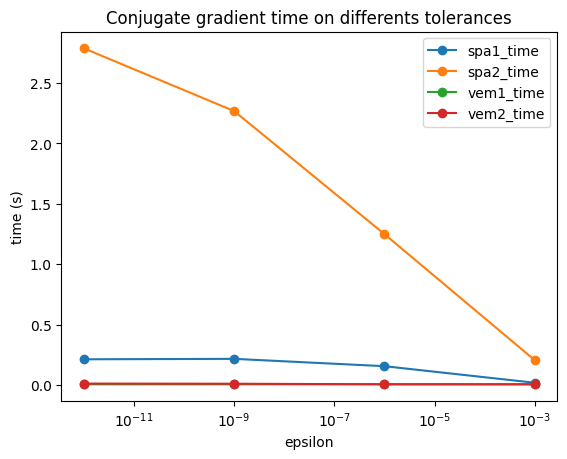

In [50]:
conjugate_gradient_epsilon_df[['epsilon', 'spa1_time', 
                    'spa2_time', 'vem1_time', 'vem2_time']].plot(x='epsilon', kind='line', ylabel='time (s)', 
                                                                logx=True, marker='o', 
                                                                title='Conjugate gradient time on differents tolerances')

plt.show() 

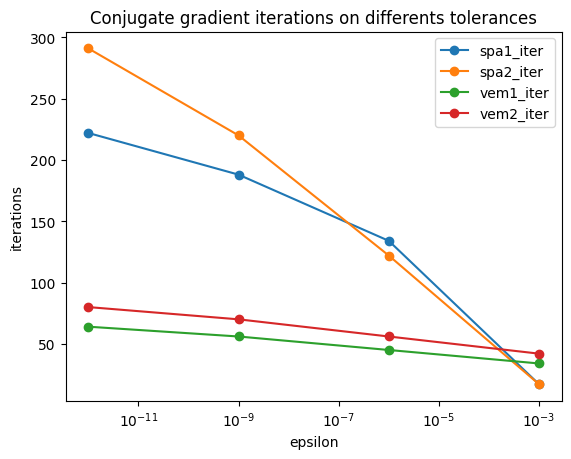

In [51]:
conjugate_gradient_epsilon_df[['epsilon', 'spa1_iter', 
                        'spa2_iter', 'vem1_iter', 'vem2_iter']].plot(x='epsilon', kind='line', ylabel='iterations', 
                                                                logx=True, marker='o', 
                                                                title='Conjugate gradient iterations on differents tolerances')
plt.show()

In [52]:
conjugate_gradient_sparsity_df = pd.DataFrame([(matrixes_names[i], matrixes[i].shape[0], matrixes[i].count_nonzero(), matrixes[i].count_nonzero() / (matrixes[i].shape[0] * matrixes[i].shape[1])) for i in range(len(matrixes))],
                                    columns=['name', 'N', 'nonzero_entries', 'sparsity_index'])

row = 2
conjugate_gradient_sparsity_df['time (s)'] = conjugate_gradient_epsilon_df.loc[row, [name + '_time' for name in matrixes_names]].values
conjugate_gradient_sparsity_df['iter'] = conjugate_gradient_epsilon_df.loc[row, [name + '_iter' for name in matrixes_names]].values

conjugate_gradient_sparsity_df  

,name,N,nonzero_entries,sparsity_index,times,iter
0,spa1,1000,182264,0.182264,0.216183,188
1,spa2,3000,1631738,0.181304,2.267832,220
2,vem1,1681,13385,0.004737,0.005301,56
3,vem2,2601,21225,0.003137,0.010181,70


## Comparazione metodi per le diverse matrici

### SPA1

In [53]:
df_spa1 = jacobi_epsilon_df[['epsilon', 'spa1_time', 'spa1_iter']]
df_spa1.columns = ['epsilon', 'jacobi_time', 'jacobi_iter']
df_spa1 = df_spa1.merge(gauss_seidel_epsilon_df[['epsilon', 'spa1_time', 'spa1_iter']], on='epsilon')
df_spa1.columns = list(df_spa1.columns)[:-2] + ['gauss_seidel_time', 'gauss_seidel_iter']
df_spa1 = df_spa1.merge(gradient_epsilon_df[['epsilon', 'spa1_time', 'spa1_iter']], on='epsilon')
df_spa1.columns = list(df_spa1.columns)[:-2] + ['gradient_time', 'gradient_iter']
df_spa1 = df_spa1.merge(conjugate_gradient_epsilon_df[['epsilon', 'spa1_time', 'spa1_iter']], on='epsilon')
df_spa1.columns = list(df_spa1.columns)[:-2] + ['conjugate_gradient_time', 'conjugate_gradient_iter']

df_spa1

,epsilon,jacobi_time,jacobi_iter,gauss_seidel_time,gauss_seidel_iter,gradient_time,gradient_iter,conjugate_gradient_time,conjugate_gradient_iter
0,1.000000e-03,0.020908,83,0.034168,6,0.033591,44,0.018275,17
1,1.000000e-06,0.050276,182,0.114221,18,1.863628,3578,0.155478,134
2,1.000000e-09,0.085368,281,0.131654,29,5.132789,10576,0.216183,188
3,1.000000e-12,0.105535,381,0.165644,40,8.466916,17608,0.21254,222


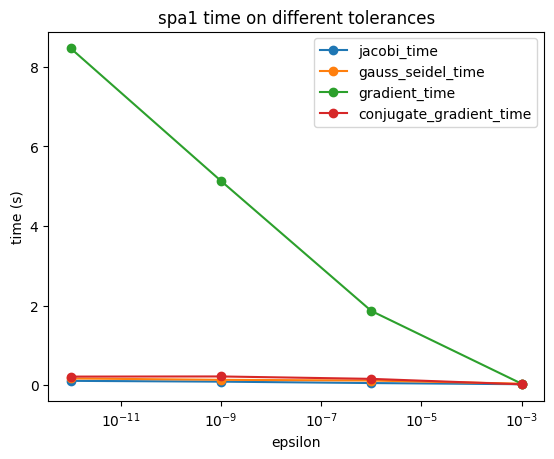

In [54]:
df_spa1[['epsilon', 'jacobi_time', 'gauss_seidel_time', 'gradient_time', 'conjugate_gradient_time']].plot(kind='line', x='epsilon', logx=True, ylabel='time (s)', 
                                                                                                            marker='o', title='spa1 time on different tolerances')

plt.show()

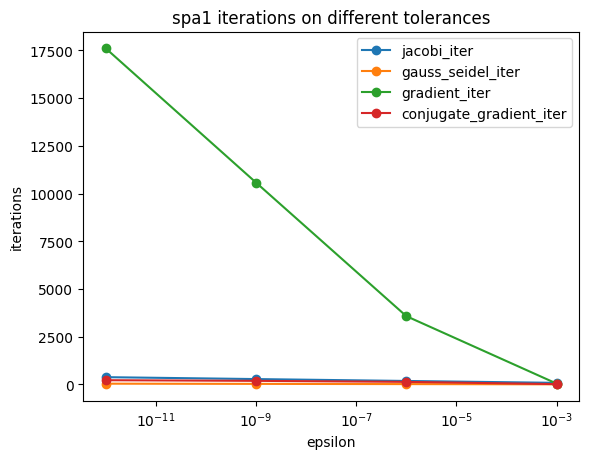

In [55]:
df_spa1[['epsilon', 'jacobi_iter', 'gauss_seidel_iter', 'gradient_iter', 'conjugate_gradient_iter']].plot(kind='line', x='epsilon', logx=True, ylabel='iterations', 
                                                                                                            marker='o', title='spa1 iterations on different tolerances')
plt.show()

### SPA2

In [56]:
df_spa2 = jacobi_epsilon_df[['epsilon', 'spa2_time', 'spa2_iter']]
df_spa2.columns = ['epsilon', 'jacobi_time', 'jacobi_iter']
df_spa2 = df_spa2.merge(gauss_seidel_epsilon_df[['epsilon', 'spa2_time', 'spa2_iter']], on='epsilon')
df_spa2.columns = list(df_spa2.columns)[:-2] + ['gauss_seidel_time', 'gauss_seidel_iter']
df_spa2 = df_spa2.merge(gradient_epsilon_df[['epsilon', 'spa2_time', 'spa2_iter']], on='epsilon')
df_spa2.columns = list(df_spa2.columns)[:-2] + ['gradient_time', 'gradient_iter']
df_spa2 = df_spa2.merge(conjugate_gradient_epsilon_df[['epsilon', 'spa2_time', 'spa2_iter']], on='epsilon')
df_spa2.columns = list(df_spa2.columns)[:-2] + ['conjugate_gradient_time', 'conjugate_gradient_iter']

df_spa2

,epsilon,jacobi_time,jacobi_iter,gauss_seidel_time,gauss_seidel_iter,gradient_time,gradient_iter,conjugate_gradient_time,conjugate_gradient_iter
0,1.000000e-03,0.065402,27,0.254119,5,0.268304,42,0.205384,17
1,1.000000e-06,0.15421,58,0.499969,9,9.634269,1950,1.249086,122
2,1.000000e-09,0.288668,89,0.667321,15,33.244131,6682,2.267832,220
3,1.000000e-12,0.301008,120,0.95134,20,55.174696,11506,2.787218,291


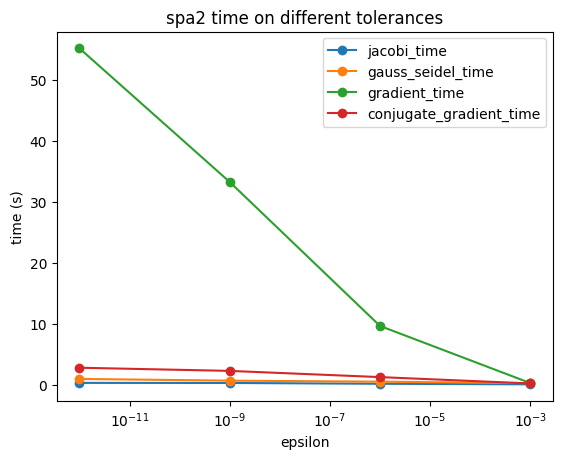

In [57]:
df_spa2[['epsilon', 'jacobi_time', 'gauss_seidel_time', 'gradient_time', 'conjugate_gradient_time']].plot(kind='line', x='epsilon', logx=True, ylabel='time (s)', 
                                                                                                            marker='o', title='spa2 time on different tolerances')

plt.show()

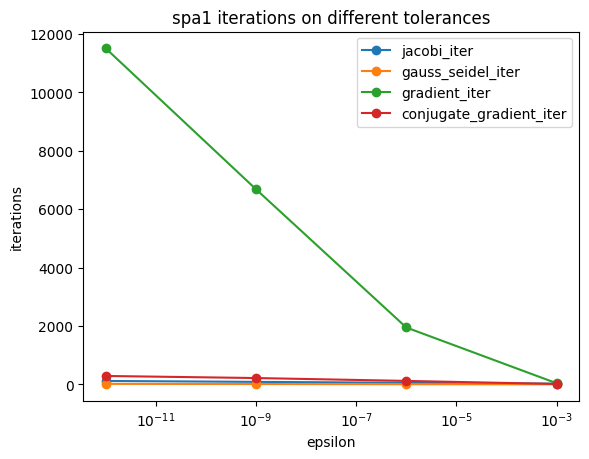

In [58]:
df_spa2[['epsilon', 'jacobi_iter', 'gauss_seidel_iter', 'gradient_iter', 'conjugate_gradient_iter']].plot(kind='line', x='epsilon', logx=True, ylabel='iterations', 
                                                                                                            marker='o', title='spa1 iterations on different tolerances')
plt.show()

### VEM1

In [59]:
df_vem1 = jacobi_epsilon_df[['epsilon', 'vem1_time', 'vem1_iter']]
df_vem1.columns = ['epsilon', 'jacobi_time', 'jacobi_iter']
df_vem1 = df_vem1.merge(gauss_seidel_epsilon_df[['epsilon', 'vem1_time', 'vem1_iter']], on='epsilon')
df_vem1.columns = list(df_vem1.columns)[:-2] + ['gauss_seidel_time', 'gauss_seidel_iter']
df_vem1 = df_vem1.merge(gradient_epsilon_df[['epsilon', 'vem1_time', 'vem1_iter']], on='epsilon')
df_vem1.columns = list(df_vem1.columns)[:-2] + ['gradient_time', 'gradient_iter']
df_vem1 = df_vem1.merge(conjugate_gradient_epsilon_df[['epsilon', 'vem1_time', 'vem1_iter']], on='epsilon')
df_vem1.columns = list(df_vem1.columns)[:-2] + ['conjugate_gradient_time', 'conjugate_gradient_iter']

df_vem1

,epsilon,jacobi_time,jacobi_iter,gauss_seidel_time,gauss_seidel_iter,gradient_time,gradient_iter,conjugate_gradient_time,conjugate_gradient_iter
0,1.000000e-03,0.028691,756,5.675789,380,0.036706,529,0.005527,34
1,1.000000e-06,0.140213,2434,17.647415,1219,0.085592,1613,0.006169,45
2,1.000000e-09,0.206349,4113,29.387856,2059,0.149694,2697,0.005301,56
3,1.000000e-12,0.260738,5791,42.008791,2898,0.200524,3783,0.005374,64


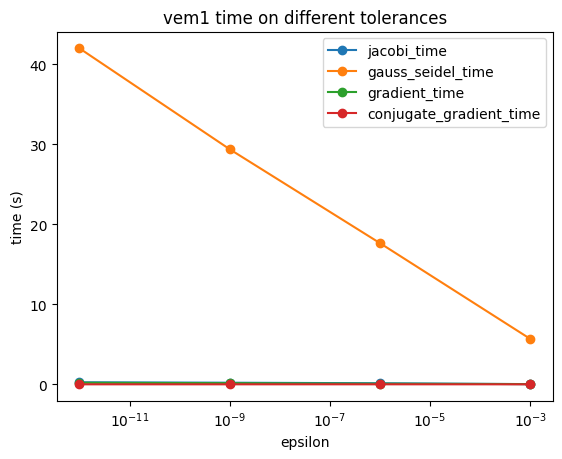

In [60]:
df_vem1[['epsilon', 'jacobi_time', 'gauss_seidel_time', 'gradient_time', 'conjugate_gradient_time']].plot(kind='line', x='epsilon', logx=True, ylabel='time (s)', 
                                                                                                            marker='o', title='vem1 time on different tolerances')

plt.show()

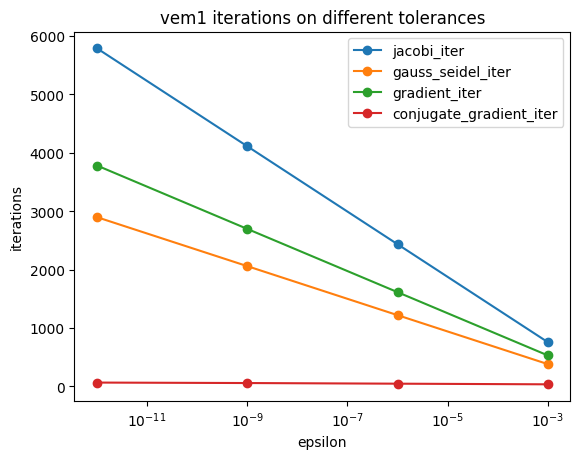

In [61]:
df_vem1[['epsilon', 'jacobi_iter', 'gauss_seidel_iter', 'gradient_iter', 'conjugate_gradient_iter']].plot(kind='line', x='epsilon', logx=True, ylabel='iterations', 
                                                                                                            marker='o', title='vem1 iterations on different tolerances')
plt.show()

### VEM2

In [62]:
df_vem2 = jacobi_epsilon_df[['epsilon', 'vem2_time', 'vem2_iter']]
df_vem2.columns = ['epsilon', 'jacobi_time', 'jacobi_iter']
df_vem2 = df_vem2.merge(gauss_seidel_epsilon_df[['epsilon', 'vem2_time', 'vem2_iter']], on='epsilon')
df_vem2.columns = list(df_vem2.columns)[:-2] + ['gauss_seidel_time', 'gauss_seidel_iter']
df_vem2 = df_vem2.merge(gradient_epsilon_df[['epsilon', 'vem2_time', 'vem2_iter']], on='epsilon')
df_vem2.columns = list(df_vem2.columns)[:-2] + ['gradient_time', 'gradient_iter']
df_vem2 = df_vem2.merge(conjugate_gradient_epsilon_df[['epsilon', 'vem2_time', 'vem2_iter']], on='epsilon')
df_vem2.columns = list(df_vem2.columns)[:-2] + ['conjugate_gradient_time', 'conjugate_gradient_iter']

df_vem2

,epsilon,jacobi_time,jacobi_iter,gauss_seidel_time,gauss_seidel_iter,gradient_time,gradient_iter,conjugate_gradient_time,conjugate_gradient_iter
0,1.000000e-03,0.060968,1054,18.331062,529,0.064317,745,0.005602,42
1,1.000000e-06,0.276124,3677,62.100137,1841,0.179305,2439,0.005453,56
2,1.000000e-09,0.375053,6300,106.721494,3153,0.283141,4131,0.010181,70
3,1.000000e-12,0.538988,8924,152.229489,4465,0.433676,5825,0.01155,80


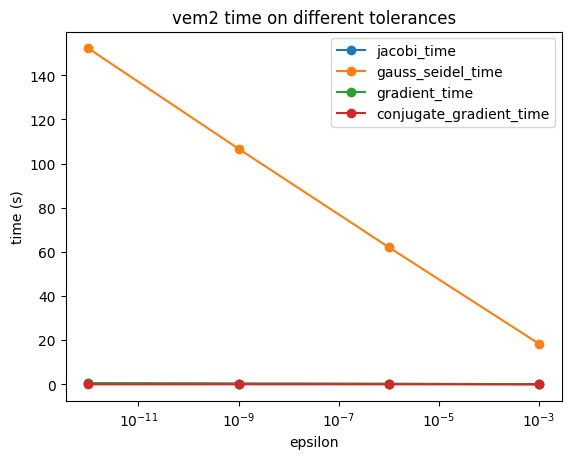

In [63]:
df_vem2[['epsilon', 'jacobi_time', 'gauss_seidel_time', 'gradient_time', 'conjugate_gradient_time']].plot(kind='line', x='epsilon', logx=True, ylabel='time (s)', 
                                                                                                            marker='o', title='vem2 time on different tolerances')

plt.show()

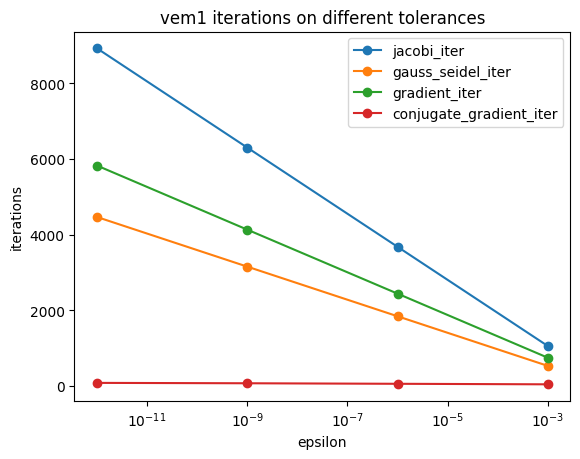

In [64]:
df_vem2[['epsilon', 'jacobi_iter', 'gauss_seidel_iter', 'gradient_iter', 'conjugate_gradient_iter']].plot(kind='line', x='epsilon', logx=True, ylabel='iterations', 
                                                                                                            marker='o', title='vem1 iterations on different tolerances')
plt.show()